In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import AutoImageProcessor, AutoModelForImageClassification

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

### Loading FashionMNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
    transforms.ToTensor()            # Convert to tensor
])

train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

### Preparing data for training with DataLoaders

In [3]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Vision Transformer

In [4]:
class ViT_VPT(nn.Module):
    def __init__(self, vit_model, prompt_size=5):
        super().__init__()
        self.vit_model = vit_model
        self.prompt_size = prompt_size
        
        # Initialize the visual prompt tokens (trainable embeddings)
        self.visual_prompts = nn.Parameter(torch.randn(1, self.prompt_size, vit_model.config.hidden_size))
        
        # Replace the classifier to output 10 classes (Fashion-MNIST has 10 classes)
        self.vit_model.classifier = nn.Linear(vit_model.config.hidden_size, 10)
        
    def forward(self, x):
        # Extract image patches using ViT's preprocessing
        inputs = self.vit_model.vit.embeddings(x) 
        # Prepend visual prompts to the each batch sequence
        batch_size = x.size(0)
        visual_prompts = self.visual_prompts.expand(batch_size, -1, -1)
        
        cls_token = inputs[:, :1, :]      
        patch_tokens = inputs[:, 1:, :] 
        
        inputs = torch.cat((cls_token, visual_prompts, patch_tokens), dim=1)
        
        # Forward pass through the model
        outputs = self.vit_model.vit.encoder(inputs)
        logits = outputs.last_hidden_state[:, 0, :]
        logits = self.vit_model.classifier(logits)
        return logits


In [5]:
# Initialize ViT with custom classifier
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
model = ViT_VPT(model)

In [6]:
# Freeze all layers except classifier and prompts
for param in model.vit_model.parameters():
    param.requires_grad = False

# Unfreeze the visual prompt tokens and classifier layers
model.visual_prompts.requires_grad = True

model.vit_model.classifier.requires_grad = True
for param in model.vit_model.classifier.parameters():
    param.requires_grad = True

In [7]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

visual_prompts
vit_model.classifier.weight
vit_model.classifier.bias


In [8]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85810186
Trainable parameters: 11530


### Model Training

In [19]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
earlystopper = EarlyStopper()

In [ ]:
# Load model from Checkpoint for contined training
# model = torch.load('ViT_VPT_fashionmnist.pth', weights_only=False)
# model.to(device);

In [22]:
# Training function
def train(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    loss /= total
    acc = 100.0 * correct / total
    return loss, acc

In [23]:
best_val_acc = 90.2
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train for several epochs
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, epoch)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion)
    
    # Store the values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(val_loss)
    test_accuracies.append(val_acc)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, "ViT_VPT_fashionmnist.pth")
        print(f"Best model saved at epoch {epoch} with Val Acc: {val_acc:.2f}%")
    
    if earlystopper.early_stop(val_loss):
        break

[Epoch 1] Train Loss: 0.2041 | Train Acc: 92.50% | Val Loss: 0.2784 | Val Acc: 90.05%


[Epoch 2] Train Loss: 0.2027 | Train Acc: 92.66% | Val Loss: 0.2805 | Val Acc: 90.09%


[Epoch 3] Train Loss: 0.2009 | Train Acc: 92.69% | Val Loss: 0.2812 | Val Acc: 89.92%


[Epoch 4] Train Loss: 0.1998 | Train Acc: 92.67% | Val Loss: 0.2874 | Val Acc: 89.95%


### Evaluation

In [ ]:
# Load model from Checkpoint
model = torch.load('ViT_VPT_fashionmnist.pth', weights_only=False)
model.to(device);

In [ ]:
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.suptitle("ViT with VPT", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig("VPT.png")  # Save as PNG
plt.show()

In [28]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))



Classification Report:
              precision    recall  f1-score   support

           0     0.8368    0.8560    0.8463      1000
           1     0.9860    0.9860    0.9860      1000
           2     0.8594    0.8740    0.8666      1000
           3     0.9023    0.8680    0.8848      1000
           4     0.8325    0.8600    0.8460      1000
           5     0.9777    0.9650    0.9713      1000
           6     0.7302    0.7010    0.7153      1000
           7     0.9339    0.9750    0.9540      1000
           8     0.9860    0.9880    0.9870      1000
           9     0.9743    0.9470    0.9604      1000

    accuracy                         0.9020     10000
   macro avg     0.9019    0.9020    0.9018     10000
weighted avg     0.9019    0.9020    0.9018     10000



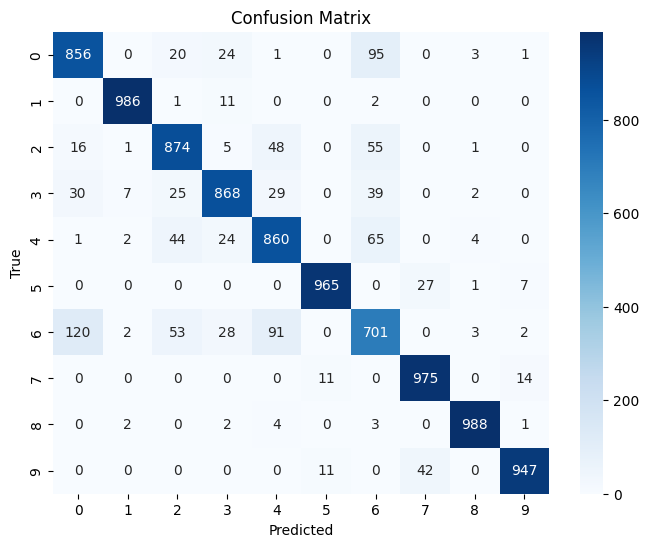

In [29]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()